In [77]:
import torch
import torchvision

In [78]:
train_dataset = torchvision.datasets.MNIST(
    root="MNIST",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_dataset = torchvision.datasets.MNIST(
    root="MNIST",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

In [79]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True
)

In [80]:
images, labels = next(iter(train_loader))

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [81]:
images[0].view(28, 28).shape

torch.Size([28, 28])

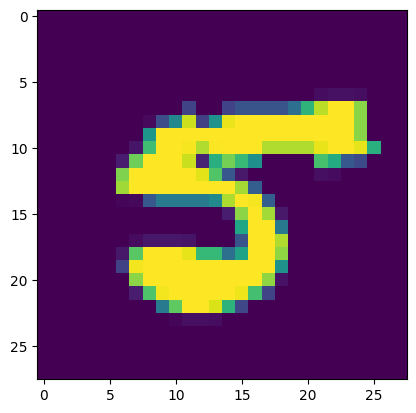

tensor(5)


In [82]:
import matplotlib.pyplot as plt

plt.imshow(images[0].view(28, 28))
plt.show()
print(labels[0])

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [84]:
input_size = 28
sequence_length = 28
num_layers = 2
hidden_size = 256
num_classes = 10
lr = 1e-3

In [85]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        return out

In [86]:
net = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [87]:
net((images[0]).to(device))

tensor([[-0.0361, -0.0069,  0.0201,  0.0151, -0.0754, -0.0085, -0.0553,  0.0611,
          0.0235, -0.0018]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [88]:
# 学習前推論
pred = net((images[0]).to(device)).max(dim=1)[1].item()
pred

7

In [89]:
true = labels[0].item()
# 推論 = 正解？
print(f"pred: {pred} true: {true}")
print("collect!") if pred == true else print("misdetect...")

pred: 7 true: 5
misdetect...


In [90]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
epochs = 5

In [96]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    net.train()
    train_loss = 0
    train_acc = 0
    for images, labels in train_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_acc += (outputs.max(1)[1] == labels).sum().item()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    net.eval()
    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        for images, labels in test_loader:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)

            val_acc += (outputs.max(1)[1] == labels).sum().item()
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)

    train_accs.append(avg_train_acc)
    train_losses.append(avg_train_loss)
    val_accs.append(avg_val_acc)
    val_losses.append(avg_val_loss)

    print(
        f"Epoch[{epoch+1}/{epochs}] train_acc: {avg_train_acc:.4f}, train_loss: {avg_train_loss:.4f}, val_acc: {avg_val_acc:.4f}, val_loss: {avg_val_loss:.4f}"
    )

Epoch[1/5] train_acc: 0.9782, train_loss: 0.0006, val_acc: 0.9713, val_loss: 0.0008
Epoch[2/5] train_acc: 0.9799, train_loss: 0.0005, val_acc: 0.9683, val_loss: 0.0010
Epoch[3/5] train_acc: 0.9796, train_loss: 0.0006, val_acc: 0.9766, val_loss: 0.0007
Epoch[4/5] train_acc: 0.9813, train_loss: 0.0005, val_acc: 0.9823, val_loss: 0.0005
Epoch[5/5] train_acc: 0.9830, train_loss: 0.0005, val_acc: 0.9751, val_loss: 0.0008


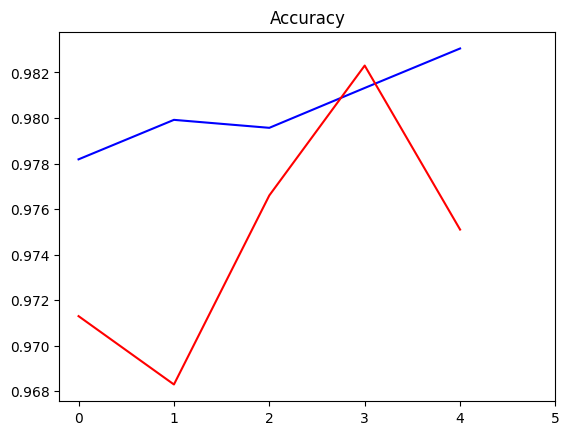

In [103]:
import matplotlib.pyplot as plt

plt.plot(train_accs, color="blue")
plt.plot(val_accs, color="red")
plt.title("Accuracy")
plt.xticks(torch.arange(0, 6, 1))
plt.show()

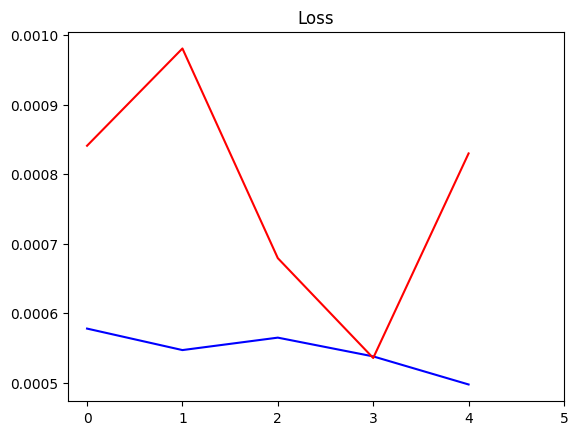

In [100]:
plt.plot(train_losses, color="blue")
plt.plot(val_losses, color="red")
plt.title("Loss")
plt.xticks(torch.arange(0, 6, 1))
plt.show()